In [1]:
import copy
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics import Accuracy

import lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 # Set to your device
torch.set_float32_matmul_precision('medium')
import json

In [2]:
train_dfs= pd.read_pickle("./data/train_data.pickle")
test_dfs= pd.read_pickle("./data/test_data.pickle")
val_dfs= pd.read_pickle("./data/val_data.pickle")

In [4]:
def encode_cnn(dfs,step=1):
    
    L = len(dfs)
    input_list = [] 
    output_list = [] 
    index_list = []
    
    target_list = ['X','P','O','D','S']
    # Processing into array for NN
    for i in range(0,L,step):
        row = dfs.iloc[i]
        ja = row['joint_action']
        ja = ja.replace("\'","\"")
        y_act = json.loads(ja)
        player_idx = row['player_idx']

        # Action / Output / GT
        y_row = y_act[player_idx]
        y=-1
        if y_row == 'INTERACT':
            y=0
        elif y_row[0]==1:
            y=1
        elif y_row[0]==-1:
            y=2
        elif y_row[1]==1:
            y=3
        elif y_row[1]==-1:
            y=4
        else:
            print("Unknown Action", y, i, player_idx, y_act)
            continue
        
        map_layout = row['layout']
        map_layout = map_layout.replace("\'","\"")
        map_layout = json.loads(map_layout)

        x = np.zeros([15,5,9]) #biggest map size
        state = json.loads(row['state'])
        

        ## partial 8-10, 11-14

        for player in [state['players'][player_idx], state['players'][(player_idx+1)%2]]:
            #Position
            player_pos = (player['position'][0],player['position'][1])
            #Orientation
            player_or = (player['orientation'][0],player['orientation'][1])

            or_idx = 11
            if player_idx==1:
                or_idx = 13
            
            x[or_idx, player_pos[1],player_pos[0]] = player_or[0]
            x[or_idx+1, player_pos[1],player_pos[0]] = player_or[1]

            #Held object converter
            if player["held_object"] is None:
                pass
            else:
                if player["held_object"]['name'] == "onion":
                    x[8, player_pos[1],player_pos[0]] = 1
                elif player["held_object"]['name'] == "dish":
                    x[9, player_pos[1],player_pos[0]] = 1
                elif player["held_object"]['name'] == "soup":
                    x[10, player_pos[1],player_pos[0]] = 1
                else:
                    print("unknown held item", player["held_object"]['name'])

        ## 0-5
        for map_row_idx in range(len(map_layout)):
            for map_col_idx in range(len(map_layout[0])):
                # 0
                x[0,map_row_idx,map_col_idx]=1

                # 1-5
                tile = map_layout[map_row_idx][map_col_idx]
                for target_idx in range(len(target_list)):
                    if target_list[target_idx] == tile:
                        x[target_idx+1, map_row_idx,map_col_idx] = 1

        ## partial 8-10, 6-7
        object_list = state['objects']
        for obj in object_list:
            obj_name = obj['name']
            obj_pos = obj['position']

            if obj_name == "onion":
                x[8, obj_pos[1],obj_pos[0]] = 1
            elif obj_name == "dish":
                x[9, obj_pos[1],obj_pos[0]] = 1
            elif obj_name == "soup":
                x[6, obj_pos[1],obj_pos[0]] = len(obj['_ingredients'])/3
                x[10, obj_pos[1],obj_pos[0]] = 1
                if obj['is_ready']:
                    x[7, obj_pos[1],obj_pos[0]] = obj['cooking_tick']/20
        
        input_list.append(x)
        output_list.append(y)
        index_list.append(row['Unnamed: 0'])

    return input_list, output_list, index_list
    

In [27]:
# Dataset Class
class OCData(Dataset):
    def __init__(self, input_list, output_list, z,  transform=False):
        self.input = input_list
        self.output = output_list
        self.transform = transform
        self.z = z
    def __len__(self):
        return len(self.output)

    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.output[idx]
        z = self.z[idx]

        rand1 = np.random.rand()
        rand2 = np.random.rand()
        
        if self.transform:
            
            if rand1>0.5:
                # x = np.flip(x,1) #axis 1 is rows (swaps rows)
                x[12,:,:]=-x[12,:,:]
                x[14,:,:]=-x[14,:,:]

                if y==3:
                    y=4
                elif y==4:
                    y=3
                    
            if rand2>0.5:
                # x = np.flip(x,2) #axis 2 is cols (swaps cols)
                x[11,:,:]=-x[11,:,:]
                x[13,:,:]=-x[13,:,:]
                
                if y==1:
                    y=2
                elif y==2:
                    y=1

        x = torch.tensor(x,dtype=torch.float32).to(device=device)

        if self.transform:
            if rand1>0.5:
                x = transforms.functional.vflip(x)
            if rand2>0.5:
                x = transforms.functional.hflip(x)
        return x,y,z

In [28]:
def norm_stats(ds):
    ds = np.array(ds)
    means = (np.mean(ds,axis=0))
    stds = (np.std(ds,axis=0))
    print(means.shape,stds.shape)
    return means, stds


In [29]:
def create_loader(train_dfs, val_dfs, test_dfs):
    #Training Dataloader
    input_list, output_list, index_list = encode_cnn(train_dfs)
    # means, stds = norm_stats(input_list)

    
    train_dataset = OCData(input_list,output_list,index_list, transform=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)

    #Validation loader
    input_list, output_list, index_list = encode_cnn(val_dfs)
    val_dataset = OCData(input_list,output_list,index_list)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

    #Test loader
    input_list, output_list, index_list = encode_cnn(test_dfs)
    test_dataset = OCData(input_list,output_list,index_list)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

train_loader, valid_loader, test_loader = create_loader(train_dfs, val_dfs, test_dfs)

In [33]:
# We will use modular convolutional blocks. 
# Define a convolutional layer along with an activation function
# Remember, you can use other techniques you have learnt from the lectures and workshops such as dropout, batchnorm, pooling etc.

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out,stride=1):
        super(ConvBlock, self).__init__()     # Call constructor
        middle_channel = (channels_in+channels_out)//2
        print(middle_channel)
        self.conv1 = nn.Conv2d(in_channels=channels_in,out_channels=middle_channel, kernel_size=3,stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=middle_channel,out_channels=channels_out, kernel_size=3,stride=stride, padding=1)
        self.activ = nn.LeakyReLU()
        #self.batchnorm1 = nn.BatchNorm2d(middle_channel)
        #self.batchnorm2 = nn.BatchNorm2d(channels_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activ(x)

        x = self.conv2(x)
        x = self.activ(x)
        return x

#Let's create a simple CNN for image classification
class Simple_CNN(pl.LightningModule):
    
    def __init__(self, num_classes=6, learning_rate=5e-4):
        super().__init__()
        M = 32

        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()

        self.batch_norm1 = nn.BatchNorm2d(15)
        self.batch_norm2 = nn.BatchNorm2d(M)

        
        # Initialise at least 2 convolutional blocks with
        self.conv_blk1 = ConvBlock(15, M)
        self.conv_blk2 = ConvBlock(M, 64)
        
        # You can use other layers too, feel free to define them here
        # self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=10)
        self.dropout = nn.Dropout(0.2)
        
        # You will need to define your fully connected layer:
        self.fc1 = nn.Linear(64*10*10,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, num_classes)

        self.leaky_relu = nn.LeakyReLU()
        
        # Define your accuracies        
        self.train_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass",num_classes=num_classes)
        
        
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout(x)
        # identity = x
        x = self.conv_blk1(x)
        x = self.batch_norm2(x)

        # x += identity
        x = self.dropout(x)
        x = self.conv_blk2(x)
        x = self.gap(x)

        x = torch.flatten(x,start_dim=1)
        x = self.dropout(x)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))

        return x
    
    def training_step(self, batch, batch_idx):
        x, y, z= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        acc = self.train_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        train_dict = {"train_loss": loss,
                    "train_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(train_dict, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y, z= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)
        acc = self.val_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        val_dict = {"val_loss": loss,
                    "val_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(val_dict, prog_bar=True, on_step=False, on_epoch=True)
    
        

    def test_step(self, batch, batch_idx):
        x, y, z= batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)
        acc = self.test_accuracy.compute()

        # Record accuracy and loss
        # Log anything you think necessary
        test_dict = {"test_loss": loss,
                    "test_acc": acc,
                    "epoch": self.current_epoch}
        
        self.log_dict(test_dict, prog_bar=True, on_step=False, on_epoch=True)

        return preds, logits, x, y
    
    def predict_step(self, batch, batch_idx):
        x, y, z = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # Compute accuracy
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        return preds, logits, x, y, z

        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),self.learning_rate, weight_decay=1e-4)
        return optimizer

    ##########
    # DATA RELATED HOOKS
    ##########

    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return valid_loader
    def test_dataloader(self):
        return test_loader

In [34]:
# Initialize the CNN model
max_epochs = 80 # Feel free to change this
model_cnn = Simple_CNN()

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_section/v4/",
        save_top_k=1,        
        mode="min",
        every_n_epochs=1
    )

# Create customized progress bar theme (Optional)
progress_bar_task = RichProgressBar(refresh_rate=1, leave=True,
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82"
    )
)

# Call the Trainer and train the model
early_stopping = EarlyStopping('val_loss', patience = 10, mode = 'min')
trainer_task = pl.Trainer(
    accelerator="auto",
    devices=1, #if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[progress_bar_task, checkpoint_callback,early_stopping],
    logger=CSVLogger(save_dir="logs_task/v4/"),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


23
48


In [35]:
trainer_task.fit(model_cnn)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name           ┃ Type               ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ criterion      │ CrossEntropyLoss   │      0 │
│ 1  │ batch_norm1    │ BatchNorm2d        │     30 │
│ 2  │ batch_norm2    │ BatchNorm2d        │     64 │
│ 3  │ conv_blk1      │ ConvBlock          │  9.8 K │
│ 4  │ conv_blk2      │ ConvBlock          │ 41.6 K │
│ 5  │ gap            │ AdaptiveAvgPool2d  │      0 │
│ 6  │ dropout        │ Dropout            │      0 │
│ 7  │ fc1            │ Linear             │  1.6 M │
│ 8  │ fc2            │ Linear             │ 32.9 K │
│ 9  │ fc3            │ Linear             │    774 │
│ 10 │ leaky_relu     │ LeakyReLU          │      0 │
│ 11 │ train_accuracy │ MulticlassAccuracy │      0 │
│ 12 │ val_accuracy   │ MulticlassAccuracy │      0 │
│ 13 │ test_accuracy  │ MulticlassAccuracy │      0 │
└────┴────────────────┴────────────────────┴────────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [36]:
torch.save(model_cnn,"./models/v4/model_tf_2ch(26).pt")
# model_cnn = torch.load("./models/v4/model_notf_75_76.pt")

In [37]:
trainer_task.test(model_cnn,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\Dylan\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │           56.0            │
│         test_acc          │    0.7002031803131104     │
│         test_loss         │    0.8972612619400024     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8972612619400024,
  'test_acc': 0.7002031803131104,
  'epoch': 56.0}]

56


C:\Users\Dylan\AppData\Local\Temp\ipykernel_10216\2881187750.py:11: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(metrics_task["train_loss"][0:epochs-1])
C:\Users\Dylan\AppData\Local\Temp\ipykernel_10216\2881187750.py:12: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(metrics_task["val_loss"][0:epochs-1])
C:\Users\Dylan\AppData\Local\Temp\ipykernel_10216\2881187750.py:21: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(metrics_task["train_acc"][0:epochs-1])
C:\Users\Dylan\A

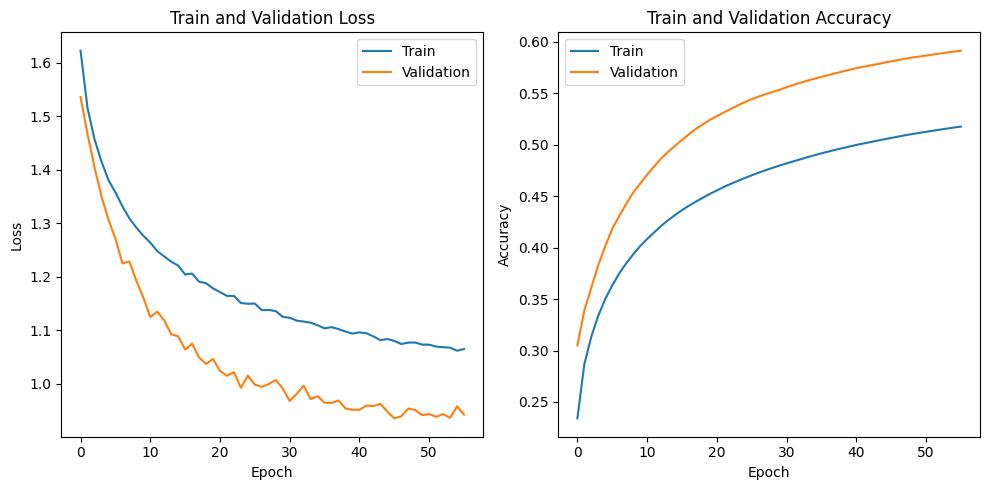

In [38]:
METRICS_PATH = "./logs_task/v4/lightning_logs/version_26"
metrics_task = pd.read_csv(METRICS_PATH + "/metrics.csv")
metrics_task.set_index("epoch", inplace=True)
metrics_task = metrics_task.groupby(level=0).sum().drop("step", axis=1)

plt.rcParams["figure.figsize"] = (10, 5)

plt.subplot(1,2,1)
epochs = len(metrics_task)-1
print(epochs)
plt.plot(metrics_task["train_loss"][0:epochs-1])
plt.plot(metrics_task["val_loss"][0:epochs-1])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train and Validation Loss")
plt.legend(["Train", "Validation"]);

plt.subplot(1,2,2)

plt.plot(metrics_task["train_acc"][0:epochs-1])
plt.plot(metrics_task["val_acc"][0:epochs-1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Train and Validation Accuracy")
plt.legend(["Train", "Validation"]);

plt.tight_layout();

In [39]:
# Concatenate the predictions from multiple batches
model_cnn.eval()
predictions = trainer_task.predict(model_cnn,test_loader)
test_indices = torch.cat([prediction[4] for prediction in predictions], dim=0)  # Concatenate model outputs
test_outputs = torch.cat([prediction[1] for prediction in predictions], dim=0)  # Concatenate model outputs
test_labels = torch.cat([prediction[3] for prediction in predictions], dim=0)  # Concatenate true labels
test_inputs = torch.cat([prediction[2] for prediction in predictions], dim=0)  # Concatenate input images
# Determine the predicted labels by selecting the class with the highest probability
test_preds = torch.cat([prediction[0] for prediction in predictions], dim=0)#test_outputs.argmax(dim=1)  # Find the index of the maximum probability along the classes (predicted labels)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

c:\Users\Dylan\anaconda3\envs\pytorch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


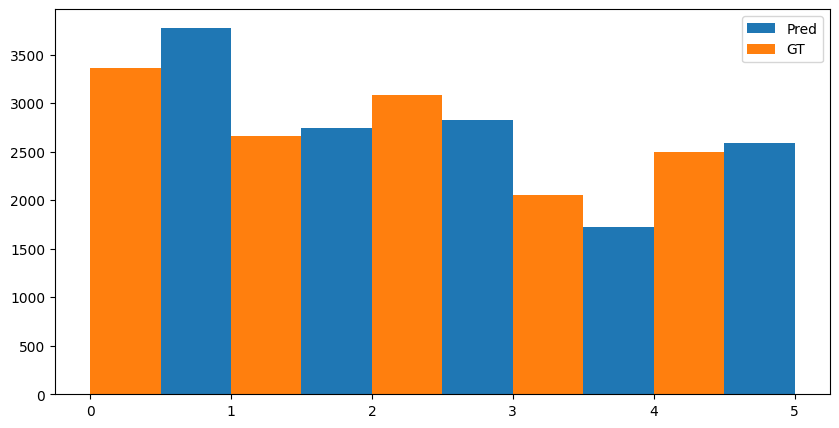

In [40]:
plt.hist(test_preds+0.5,bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],label="Pred");
plt.hist(test_labels,bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],label="GT");
plt.legend()
plt.show()

In [41]:
def saliency(index,plot=False, save_plot=False):
    # Retrieve the input image, true label, model output, predicted label for the selected index
    pred = test_preds[index]
    label = test_labels[index]
    output = test_outputs[index]
    image_original = test_inputs[index]
    test_index = test_indices[index]

    # Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
    image = image_original.unsqueeze(0)
    image.requires_grad = True

    # Compute the scores and gradients for the input image
    # To compute the scores, do a forward pass of the image and then take the argmax
    # Use this index to extract the score_max value from "scores"
    # Then perform a backward step so that it backpropagates the gradient
    model_cnn.eval()
    scores = model_cnn.forward(image)
    score_max_index = torch.argmax(scores)
    score_max = scores[0, score_max_index]
    score_max.backward() # Do the backward step here for the gradient calculation

    # Calculate the saliency map by finding the maximum absolute gradient values across channels
    # You can use .abs() and torch.max()
    grad = image.grad
    grad_abs = torch.squeeze(grad.abs())
    grad_max = torch.max(grad_abs,dim=0).values


    # # Create a subplot to display the original image and saliency map side by side
    if plot or save_plot:
        actions_list = ["INT","Right","Left","Down","Up"]
        plt.close()
        plt.figure()

        # Create a subplot to display the original image and saliency map side by side
        plt.rcParams["figure.figsize"] = (10, 10)
        plt.subplot(1,2,1)
        plt.imshow(grad_max)
        plt.title(f"Saliency (Max)\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {test_index}")
        plt.axis('off')

        #Original Image
        plt.subplot(1,2,2)
        plt.title(f"Original (Blue)\nPred: {actions_list[pred.item()]}, GT: {actions_list[label.item()]}, Index: {test_index}")
        image_disp = torchvision.io.read_image(f"./data/imgs/test/{label.item()}/{test_index}.png")
        image_disp_rgb = image_disp.permute(1,2,0)

        # plt.title(f"Map: {test_index}")
        plt.axis('off')
        plt.imshow(image_disp_rgb)
        plt.tight_layout()

        if plot:
            plt.show()
            print("Probabilities:",torch.nn.functional.softmax(output))

        if save_plot:
            plt.savefig(fname=f"./results/v4/{test_index}.png")
        
    return grad_abs, image_original

In [18]:
# Plot saliency of a data point
# saliency(0,True);

# # Get saliency stats and save results
grad_stats = []
input_stats = []
for index in range(len(test_labels)):
    grad_stat, input_stat = saliency(index, False, False)
    grad_stats.append(np.array(grad_stat))
    input_stats.append(np.array(input_stat))


np.save("./results/v4/stats_2_tf.npy",np.array(grad_stats))
np.save("./results/v4/stats_inputs_2_tf.npy",np.array(input_stats))

[11055  8915  1318  7221 11468  7540   664  6137  6833  8471  9449  7322
  8222  1182  7916  8060  7962 10682 10360  7644 11589 11600  9161  2431
   246  2558  3503  5682  3824  5883  5196 12198  1530 13507 10983  7307
  6784  4841 12107 10576     3  1282  1299 11148  6603  4467  3691 11278
  3315 10695 12092  8682  6763  4014  7068  3153  9047  9997  4212 12896
 11148 12485   625  3039  8165 11935  8953 13308 11865  9300 10285  2576
 12329 12216  5206  8108   986 11219  2351  5138  9813  9902  2530 12069
  6950 12423  3044  1731  1774  2607  3062 10484 10614  8879  9103  2594
    10  3356  5124  2130]


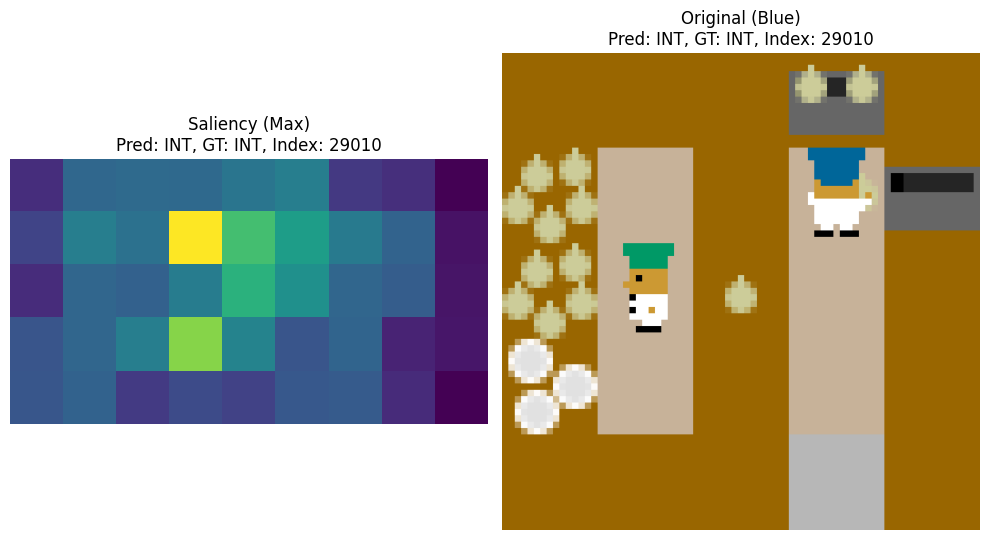

In [18]:
# np.random.seed(1234)
# results_indices = np.random.randint(0,len(test_dfs),size=100)
# print(results_indices)

# for index in results_indices:
#     _ = saliency(index, False, True)